In [1]:
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

## Define brain, find trace data folder

In [2]:
#specify brain1 or brain2 below
brain = "brain1"

root_dir = Path(os.path.abspath('')).parents[1]
experiment_dir = os.path.join(root_dir, "axon_geometry")
data_dir = os.path.join(experiment_dir, "data", brain)
segments_swc_dir = os.path.join(data_dir, "segments_swc")
trace_data_dir = os.path.join(data_dir, "trace_data")
trace_data_dir = os.path.join(trace_data_dir, "14")
print(f"Directory where swcs reside: {segments_swc_dir}")

Directory where swcs reside: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/axon_geometry/data/brain1/segments_swc


## Read trace data

In [3]:
max_id = 300


def classify_height(row):
    height = row["height"]
    if height <= 2:
        return height
    else:
        return 3

def numerical_class(row):
    _class = row["class"]
    if _class == "axon":
        return 0
    if _class == "collateral":
        return 1
    if _class == "terminal":
        return 2

df_path = os.path.join(trace_data_dir, "df.csv")
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
else:
    df = pd.DataFrame(columns=["seg_id", "class", "height", "log_seg_length", "measure", "value", "log_value"])
    for i in np.arange(0, max_id):
        i = int(i)
        trace_data_path = os.path.join(trace_data_dir, "{}.npy".format(i))
        if os.path.exists(trace_data_path) is True:
            trace_data = np.load(trace_data_path, allow_pickle=True)
            print("Loaded segment {}".format(i))

            for node in trace_data:
                seg_length = node["seg_length"]
                height = node["height"]
                _class = node["class"]
                mean_curvature = node["mean_curvature"]
                mean_torsion = node["mean_torsion"]
                
                log_seg_length = np.log10(seg_length)

                log_mean_curvature = np.log10(mean_curvature)
                df = df.append({"seg_id": i, "height": height, "class": _class, "log_seg_length": log_seg_length, "measure": "curvature", "value": mean_curvature, "log_value": log_mean_curvature}, ignore_index=True)

                log_mean_torsion = np.log10(mean_torsion)
                df = df.append({"seg_id": i, "height": height, "class": _class, "log_seg_length": log_seg_length, "measure": "torsion", "value": mean_torsion, "log_value": log_mean_torsion}, ignore_index=True)
    df.to_csv(df_path)
df["class"] = df.apply(numerical_class, axis=1)
df["height_class"] = df.apply(classify_height, axis=1)

# Evaluate mean and variance of curvature/torsion distributions based on spline class

In [9]:
measures = ["curvature", "torsion"]
class_dict = {0: "primary", 1: "collateral", 2: "terminal"}

for measure in measures:
    measure_df = df[df["measure"] == measure]
    for class_id in class_dict:
        class_name = class_dict[class_id]
        class_values = measure_df[measure_df["class"] == class_id]["value"]
        class_mean = class_values.mean()
        class_var = class_values.var()
        print(f"{class_name} {measure}, mu = {class_mean}, var = {class_var}")

primary curvature, mu = 0.014485661038769956, var = 4.521479594185378e-05
collateral curvature, mu = 0.05404616880135591, var = 0.005278548565552187
terminal curvature, mu = 0.038682121760974165, var = 0.008461645746110882
primary torsion, mu = 0.050539976879160155, var = 0.0002245179215100793
collateral torsion, mu = 0.07687244948036277, var = 0.0072358893460061505
terminal torsion, mu = 0.03291583251668538, var = 0.007683391715019156


# Scatter plots of `log` curvature/torsion against `log` segment length as a function of spline class

In [ ]:
g = sns.FacetGrid(df, row="measure", col="class", hue="class", height=4)
g.map(sns.scatterplot, "log_seg_length", "log_value", marker='.', s=50)
g.set_axis_labels(r"$\log$ segment length", r"$\log$ mean value")
g.set(ylim=[-4, 1])
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")

axes = g.axes
for i, measure in enumerate(["curvature", "torsion"]):
    for j, _class in enumerate(["primary", "collateral", "terminal"]):
        ax = axes[i, j]
        ax.set_title(f"{measure} | {_class}")
        
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_mean_value_class_scatter.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_mean_value_class_scatter.jpg"))

## Pairwise Wilcoxon Sum Ranked test and Kolgomorov-Smirnoff test

100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


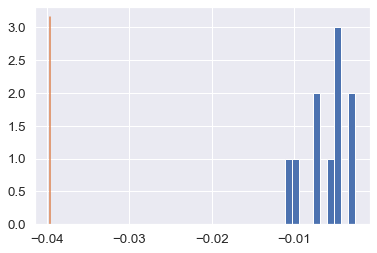

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


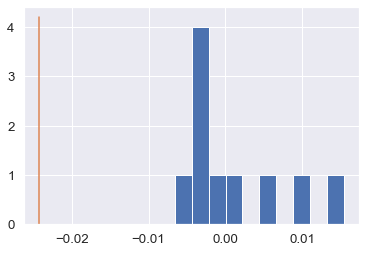

 20%|██        | 2/10 [00:03<00:14,  1.85s/it]


KeyboardInterrupt: 

In [34]:
n_perms = 10
p_df = pd.DataFrame(columns=["measure", "first_sample", "second_sample", "wilcoxon_p", "ks_p"])

test_name = "ks"
test_f = scipy.stats.kstest

measures = ["curvature", "torsion"]

classes = {0: "primary", 1: "collateral", 2: "terminal"}
n = len(classes)
matrix_pairs = np.triu(np.ones((n, n)), k=1)
(coord_pairs_x, coord_pairs_y) = np.where(matrix_pairs == 1)

for measure in measures:
    for x, y in zip(coord_pairs_x, coord_pairs_y):
        test_stats = []
        for perm in tqdm(range(n_perms)):
            x_sample = []
            y_sample = []
            for i in np.arange(0, max_id):
                sample_query = df.loc[(df['seg_id'] == i) & ((df['class'] == x) | (df['class'] == y)) & (df['measure'] == measure)]
                    
                values = sample_query["value"].to_numpy()
                classes = sample_query["class"].to_numpy()

                #if neuron with seg_id i exists
                if values.shape[0] > 1:
                    classes_permuted = np.random.permutation(classes)
                    x_sample.append(values[classes_permuted == x])
                    y_sample.append(values[classes_permuted == y])
                    
            x_sample = np.concatenate(x_sample)
            y_sample = np.concatenate(y_sample)
            dif = np.mean(x_sample) - np.mean(y_sample)
            test_stats.append(dif)
            
        first_sample_query = df.loc[(df['class'] == x) & (df['measure'] == measure)]
        second_sample_query = df.loc[(df['class'] == y) & (df['measure'] == measure)]
        x_sample = first_sample_query["value"].to_numpy()
        y_sample = second_sample_query["value"].to_numpy()
        dif = np.mean(x_sample) - np.mean(y_sample)

        plt.hist(test_stats)
        plt.plot([dif, dif],[0,plt.ylim()[1]])
        plt.show()
            
        #p_df = p_df.append({"measure": measure, "first_sample": x, "second_sample": y, test_column: test_p}, ignore_index=True)